In [77]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [78]:
perc_expand_by_epoch = pd.read_csv('../outs/perc_expand_by_epoch_final.csv', index_col=0)
perc_expand_by_epoch_tetra = pd.read_csv('../outs/perc_expand_by_epoch_tetra_final.csv', index_col=0)
gtf_file = pd.read_csv('../data/vep/gencode.vM30.annotation.gtf.gz', skiprows=5, sep='\t', header=None)

dna_repair_genes = [item.strip() for item in open('../outs/dna-repair-genes.txt', 'r').readlines()]

In [79]:
perc_expand = perc_expand_by_epoch[perc_expand_by_epoch["epoch_grp"]=="all"]
perc_expand_tetra = perc_expand_by_epoch_tetra[perc_expand_by_epoch_tetra["epoch_grp"]=="all"]

In [80]:
def GetYCoords(values, numtotal):
    ycoords = []
    while len(ycoords) <= numtotal:
        ycoords.extend(values)
    return ycoords[0:numtotal]

# get points to plot to have the boxed square effect; get 3 points to plot from 2 data points
def get_pts(x_data, y_data):
    x_pts = []
    y_pts = []
    for i in range(len(x_data)-1):
        x_pts.append(x_data[i])
        y_pts.append(y_data[i])
        x_pts.append(x_data[i])
        y_pts.append(y_data[i+1])
    x_pts.append(x_data[-1])
    y_pts.append(y_data[-1])
    return x_pts, y_pts

['Hspa1l', 'Msh5', 'Gtf2h4', 'Mdc1']
[]
['Ccnh', 'Xrcc4', 'Msh3']


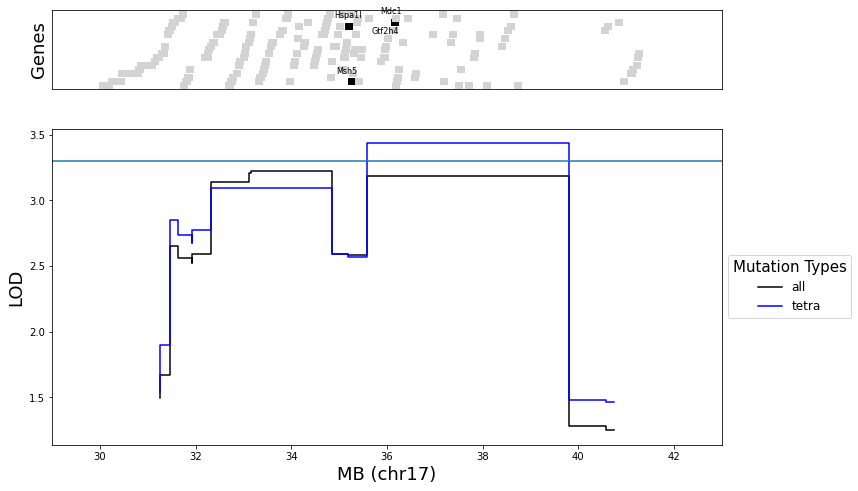

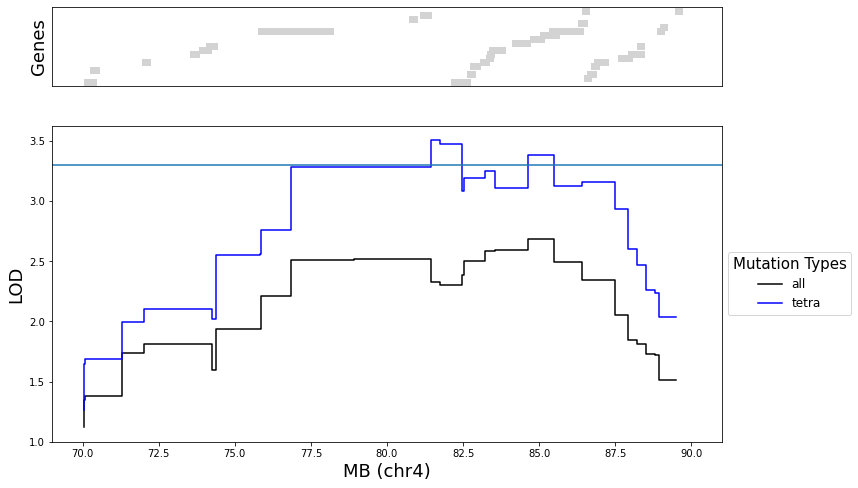

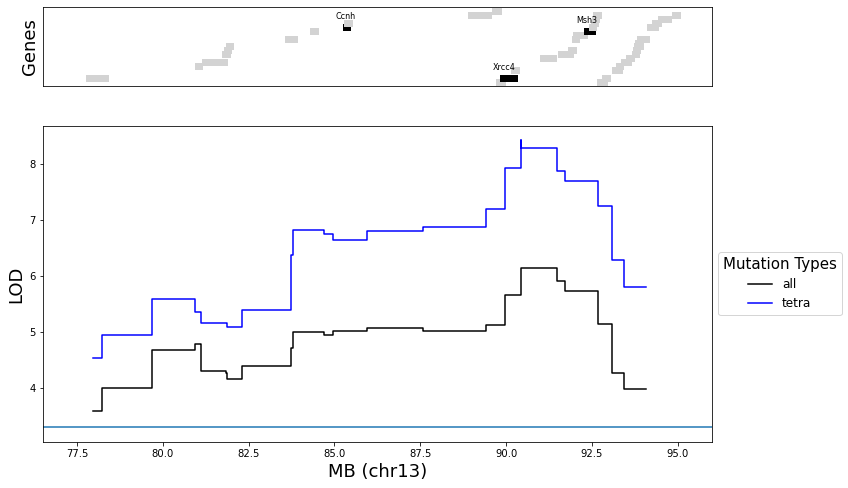

In [81]:
regions = [("chr17", 30, 42, []), ("chr4", 70, 90, []), ("chr13",77.5, 95, [])]
W = 1
for r in regions:
    pe_region = perc_expand[(perc_expand["chr"]==r[0]) & 
                           (perc_expand["pos"]>r[1]*10**6) &
                           (perc_expand["pos"]<r[2]*10**6)]
    pe_region_tetra = perc_expand_tetra[(perc_expand_tetra["chr"]==r[0]) & 
                           (perc_expand_tetra["pos"]>r[1]*10**6) &
                           (perc_expand_tetra["pos"]<r[2]*10**6)]
    gtf_region = gtf_file[(gtf_file[0]==r[0]) &
        (gtf_file[2]=="gene") &
        (gtf_file[3]>r[1]*10**6) &
        (gtf_file[4]<r[2]*10**6)].copy()
    gtf_region[8] = gtf_region[8].apply(lambda x: x.split('gene_name "')[1].split('"')[0])
    gtf_region = gtf_region[~gtf_region[8].apply(lambda x: x.startswith("Gm") or x.endswith("Rik") or x.startswith("ENSM"))]
    if len(r[3])>0:
        gtf_region = gtf_region[gtf_region[8].isin(r[3])]
    print([item for item in list(gtf_region[8]) if item in dna_repair_genes])
    fig, ax = plt.subplots(2, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 4]})
    
    #### Plot gene locations ####
    ax[0].set_xlim((r[1]-W, r[2]+W))
    ax[0].set_ylim([-10, 10])
    y_locations = GetYCoords(range(-9, 10), gtf_region.shape[0])
    count = 0

    for index, row in gtf_region.iterrows():
        x_points = [float(row[3]/10**6), float(row[4]/10**6)]
        if row[8] in dna_repair_genes:
            ax[0].plot(x_points, [y_locations[count]]*2, linewidth=7, label=row[8], color = 'black')
            ax[0].annotate(row[8], xy=(x_points[0]-0.3, y_locations[count]+2), fontsize=8)
        else:
            ax[0].plot(x_points, [y_locations[count]]*2, linewidth=7, label=row[8], color = 'lightgray')
        count += 1
    ax[0].tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax[0].set_ylabel('Genes', fontsize=18)

    #### Plot LOD epoch lines ###
    ax[1].set_xlim((r[1]-W, r[2]+W))
    x_all, y_all = get_pts(list(pe_region["pos"]/10**6),list(pe_region["LOD"]))
    x_tetra, y_tetra = get_pts(list(pe_region_tetra["pos"]/10**6),list(pe_region_tetra["LOD"]))

    ax[1].plot(x_all, y_all, label = 'all', color='black')
    ax[1].plot(x_tetra, y_tetra, label = 'tetra', color='blue')
    ax[1].axhline(y=3.3)
    ax[1].legend(title='Mutation Types', title_fontsize = 15, fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('MB (%s)'%r[0], fontsize=18)
    plt.ylabel('LOD', fontsize=18)
    fig.savefig('pdfs/LocusZoom-PercExps-%s.pdf'%r[0])